In [16]:
# Importing libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [17]:
# Setting to GPU if available
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using: {device}")

Using: cuda


Loaded image: ../data/Training/meningioma_tumor/m3 (120).jpg


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

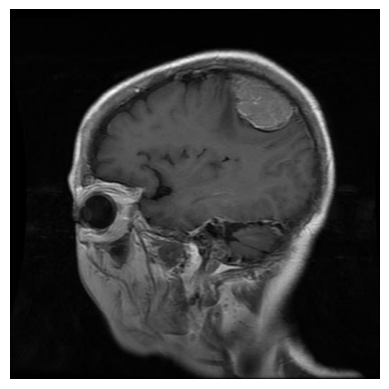

In [18]:
import os
from PIL import Image
import matplotlib.pyplot as plt

root = "../data/Training"

# Find the first image in the training folder
image_path = None
for subdir, dirs, files in os.walk(root):
    for file in files:
        if file.lower().endswith((".png", ".jpg", ".jpeg")):
            image_path = os.path.join(subdir, file)
            break
    if image_path:
        break

print("Loaded image:", image_path)

img = Image.open(image_path)
plt.imshow(img)
plt.axis("off");

In [19]:
# Preprocessing

train_transform = transforms.Compose([
    # Data Augmentation
    transforms.RandomRotation(degrees=15),
    
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# No Data Augmentation
train_dataset_simple = datasets.ImageFolder("../data/Training", transform=test_transform)
test_dataset_simple = datasets.ImageFolder("../data/Testing",  transform=test_transform)

# Augmentation for training dataset
train_dataset = datasets.ImageFolder("../data/Training", transform=train_transform)
test_dataset = datasets.ImageFolder("../data/Testing",  transform=test_transform)

train_loader_simple = DataLoader(train_dataset_simple, batch_size=64, shuffle=True)
test_loader_simple  = DataLoader(test_dataset_simple, batch_size=64, shuffle=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
# Defining a class that handles each convolution block
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        return self.block(x)

In [21]:
# Full Model Architecture
class RobustCNN(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv1 = CNNBlock(in_channels=3, out_channels=32)
        self.conv2 = CNNBlock(in_channels=32, out_channels=64)
        self.conv3 = CNNBlock(in_channels=64, out_channels=128)
        self.conv4 = CNNBlock(in_channels=128, out_channels=256)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # After pooling 4 times, 224 -> 56 -> 28 -> 14
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.classifier(x)

        return x

In [22]:
# Training and evaluation functions
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Tracking progress
        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    accuracy = correct / total

    return model, train_loss, accuracy


def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    accuracy = correct / total

    return accuracy

In [23]:
# RobustCNN - No data Augmentation
model = RobustCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 100

train_loss_ = []
train_accuracy_ = []
test_acc_ = []
for epoch in range(EPOCHS):
    print(f"\n[Training] Epoch {epoch+1}/{EPOCHS}:")
    trained_model_, loss, train_acc = train_epoch(model, train_loader_simple, criterion, optimizer, device)
    train_loss_.append(loss)
    train_accuracy_.append(train_acc)
    print((f"\tLoss - {loss} | Accuracy - {train_acc:.3f}"))

    print(f"[Testing] Epoch {epoch+1}/{EPOCHS}:")
    accuracy = evaluate(trained_model_, test_loader_simple, device)
    test_acc_.append(accuracy)
    print((f"\tAccuracy - {accuracy:.3f}"))


[Training] Epoch 1/100:
	Loss - 6.109307336807251 | Accuracy - 0.513
[Testing] Epoch 1/100:
	Accuracy - 0.274

[Training] Epoch 2/100:
	Loss - 0.7400329033533732 | Accuracy - 0.692
[Testing] Epoch 2/100:
	Accuracy - 0.312

[Training] Epoch 3/100:
	Loss - 0.6197873128785027 | Accuracy - 0.749
[Testing] Epoch 3/100:
	Accuracy - 0.477

[Training] Epoch 4/100:
	Loss - 0.5502833227316538 | Accuracy - 0.784
[Testing] Epoch 4/100:
	Accuracy - 0.508

[Training] Epoch 5/100:
	Loss - 0.47966033816337583 | Accuracy - 0.809
[Testing] Epoch 5/100:
	Accuracy - 0.543

[Training] Epoch 6/100:
	Loss - 0.44508359432220457 | Accuracy - 0.831
[Testing] Epoch 6/100:
	Accuracy - 0.571

[Training] Epoch 7/100:
	Loss - 0.4224398583173752 | Accuracy - 0.844
[Testing] Epoch 7/100:
	Accuracy - 0.546

[Training] Epoch 8/100:
	Loss - 0.35891348454687333 | Accuracy - 0.852
[Testing] Epoch 8/100:
	Accuracy - 0.652

[Training] Epoch 9/100:
	Loss - 0.3234254601928923 | Accuracy - 0.877
[Testing] Epoch 9/100:
	Accurac

In [24]:
class RobustCNN2(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.conv1 = CNNBlock(in_channels=3, out_channels=32)
        self.conv2 = CNNBlock(in_channels=32, out_channels=64)
        self.conv3 = CNNBlock(in_channels=64, out_channels=128)
        self.conv4 = CNNBlock(in_channels=128, out_channels=256)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            # After pooling 4 times, 224 -> 56 -> 28 -> 14
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.classifier(x)

        return x

In [26]:
model2 = RobustCNN2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

EPOCHS = 100

train_loss = []
train_accuracy = []
test_acc = []
for epoch in range(EPOCHS):
    print(f"\n[Training] Epoch {epoch+1}/{EPOCHS}:")
    trained_model, loss, train_acc = train_epoch(model2, train_loader_simple, criterion, optimizer, device)
    train_loss.append(loss)
    train_accuracy.append(train_acc)
    print((f"\tLoss - {loss} | Accuracy - {train_acc:.3f}"))

    print(f"[Testing] Epoch {epoch+1}/{EPOCHS}:")
    accuracy = evaluate(trained_model, test_loader_simple, device)
    test_acc.append(accuracy)
    print((f"\tAccuracy - {accuracy:.3f}"))


[Training] Epoch 1/100:
	Loss - 4.73332859939999 | Accuracy - 0.554
[Testing] Epoch 1/100:
	Accuracy - 0.340

[Training] Epoch 2/100:
	Loss - 0.8004252513249716 | Accuracy - 0.690
[Testing] Epoch 2/100:
	Accuracy - 0.447

[Training] Epoch 3/100:
	Loss - 0.672549906041887 | Accuracy - 0.721
[Testing] Epoch 3/100:
	Accuracy - 0.449

[Training] Epoch 4/100:
	Loss - 0.6050790548324585 | Accuracy - 0.743
[Testing] Epoch 4/100:
	Accuracy - 0.500

[Training] Epoch 5/100:
	Loss - 0.5493255211247339 | Accuracy - 0.772
[Testing] Epoch 5/100:
	Accuracy - 0.426

[Training] Epoch 6/100:
	Loss - 0.5032932897408803 | Accuracy - 0.793
[Testing] Epoch 6/100:
	Accuracy - 0.480

[Training] Epoch 7/100:
	Loss - 0.47995780110359193 | Accuracy - 0.798
[Testing] Epoch 7/100:
	Accuracy - 0.503

[Training] Epoch 8/100:
	Loss - 0.4658996601899465 | Accuracy - 0.811
[Testing] Epoch 8/100:
	Accuracy - 0.569

[Training] Epoch 9/100:
	Loss - 0.4763630145125919 | Accuracy - 0.794
[Testing] Epoch 9/100:
	Accuracy - 

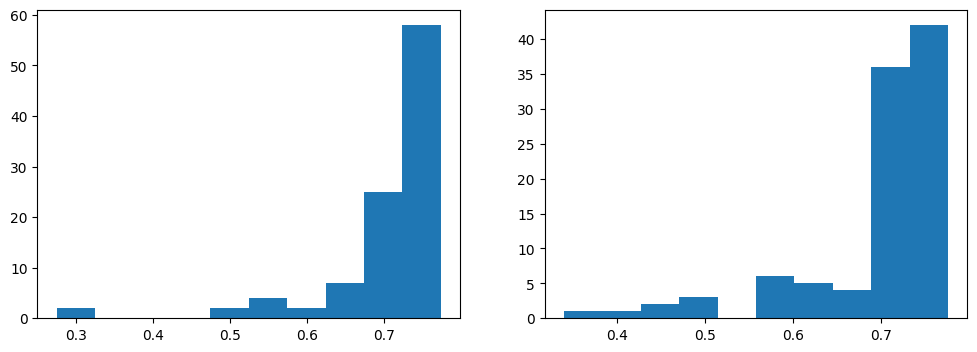

In [30]:
import numpy as np
X = np.array(test_acc_)
Y = np.array(test_acc)

_, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(X)
axes[1].hist(Y);

In [31]:
X.mean(), X.std()

(np.float64(0.7045939086294417), np.float64(0.08091862155387783))

In [32]:
Y.mean(), Y.std()

(np.float64(0.6944162436548222), np.float64(0.08280493319249883))

In [33]:
X[X > 0.74]

array([0.77411168, 0.75126904, 0.75126904, 0.75380711, 0.74111675,
       0.76142132, 0.76649746, 0.74365482, 0.75126904, 0.74873096,
       0.75888325, 0.75380711, 0.74873096, 0.75380711, 0.75634518,
       0.75126904, 0.75888325, 0.75126904, 0.76649746, 0.76649746,
       0.74873096, 0.76395939, 0.74873096, 0.74365482, 0.75634518,
       0.74873096, 0.74111675, 0.74365482, 0.75380711, 0.75380711])

In [34]:
Y[Y > 0.74]

array([0.74365482, 0.75888325, 0.74619289, 0.74365482, 0.74365482,
       0.74111675, 0.74111675, 0.74111675, 0.74873096, 0.74873096,
       0.75380711, 0.74365482, 0.75380711, 0.75380711, 0.74111675,
       0.74873096, 0.74365482, 0.74619289, 0.74619289, 0.74365482,
       0.74619289, 0.74111675, 0.74365482, 0.74619289, 0.75380711,
       0.77411168, 0.74619289, 0.74365482, 0.75126904, 0.74365482,
       0.77664975, 0.75126904, 0.75380711])